In [ ]:
!nvidia-smi

Tue Feb  9 18:48:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

In [ ]:
# find file paths
food = ['apple_pie','baby_back_ribs', 'baklava'] 
f_train_path = '/content/drive/MyDrive/Colab Projects/food_3classes/train/'
f_test_path = '/content/drive/MyDrive/Colab Projects/food_3classes/test/'
f_apple = glob.glob(f_train_path + food[0]+'/*')
f_baby = glob.glob(f_train_path + food[1]+'/*')
f_baklava = glob.glob(f_train_path + food[2]+'/*')
f_apple_test = glob.glob(f_test_path + food[0]+'/*')
f_baby_test = glob.glob(f_test_path + food[1]+'/*')
f_baklava_test = glob.glob(f_test_path + food[2]+'/*')
# total 1000 files for each category
print('Number of images per class:\n\t\ttrain\ttest \nApple_pie:\t{}\t{}\nBaby_pork_ribs:\t{}\t{}\nBaklava:\t{}\t{}'
      .format(len(f_apple),len(f_apple_test),len(f_baby),len(f_baby_test),len(f_baklava),len(f_baklava_test)))

Number of images per class:
		train	test 
Apple_pie:	750	250
Baby_pork_ribs:	750	250
Baklava:	750	250


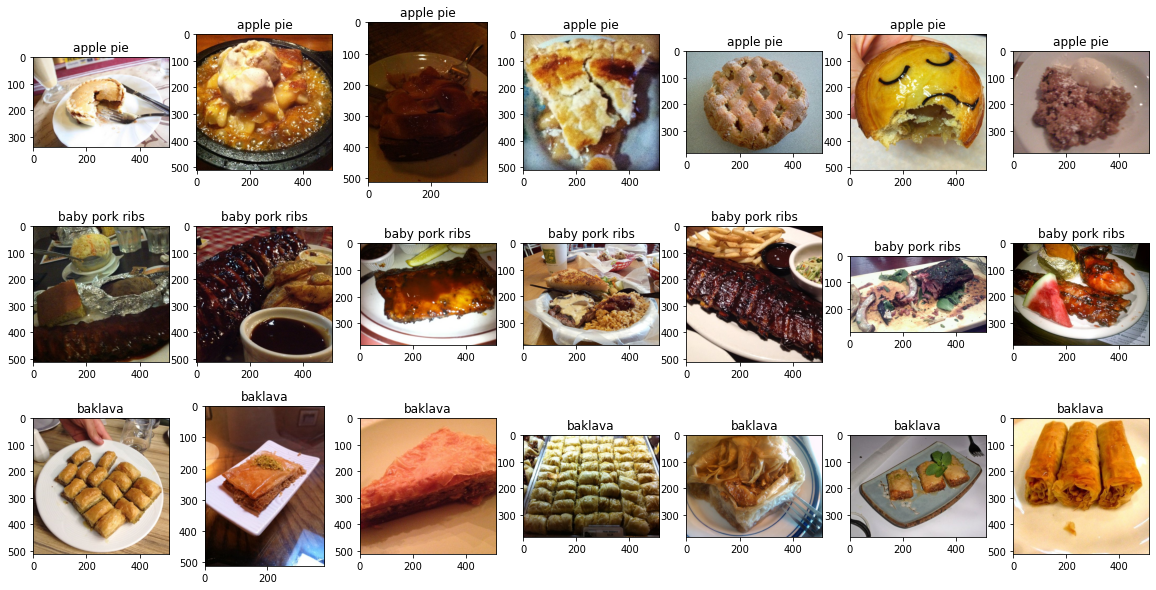

In [ ]:
# preview some images of each class
n = 7
from glob import glob
classes_number = len(glob(f_train_path + '/*'))
fig, axes = plt.subplots(classes_number,n,figsize=(20,10))

for i in range(n):
    axes[0, i].imshow(plt.imread(f_apple[i]))
    axes[0, i].set_title('apple pie')
    axes[1, i].imshow(plt.imread(f_baby[i]))
    axes[1, i].set_title('baby pork ribs')
    axes[2, i].imshow(plt.imread(f_baklava[i]))
    axes[2, i].set_title('baklava')

The images are of different sizes and aspect ratio, with at least one side of 512 pixels.

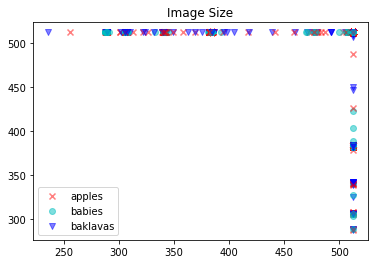

In [ ]:
for i in range(len(f_apple)):
    h1,w1,c1 = plt.imread(f_apple[i]).shape
    h2,w2,c2 = plt.imread(f_baby[i]).shape
    h3,w3,c3 = plt.imread(f_baklava[i]).shape
    plt.scatter(h1,w1,c='r',marker='x',alpha=0.5)
    plt.scatter(h2,w2,c='c',marker='o',alpha=0.5)
    plt.scatter(h3,w3,c='b',marker='v',alpha=0.5)
plt.title('Image Size')
plt.legend(('apples','babies','baklavas'))

**Data Augmentation**

In order to avoid overfitting problem and to expand the dataset. Image data generator from Keras is used for image tranformation.

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #normalize image, add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        f_train_path,
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) # just normalize for testing set
test_generator = test_datagen.flow_from_directory(
        f_test_path,
        target_size=(224,224),
        batch_size=64)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


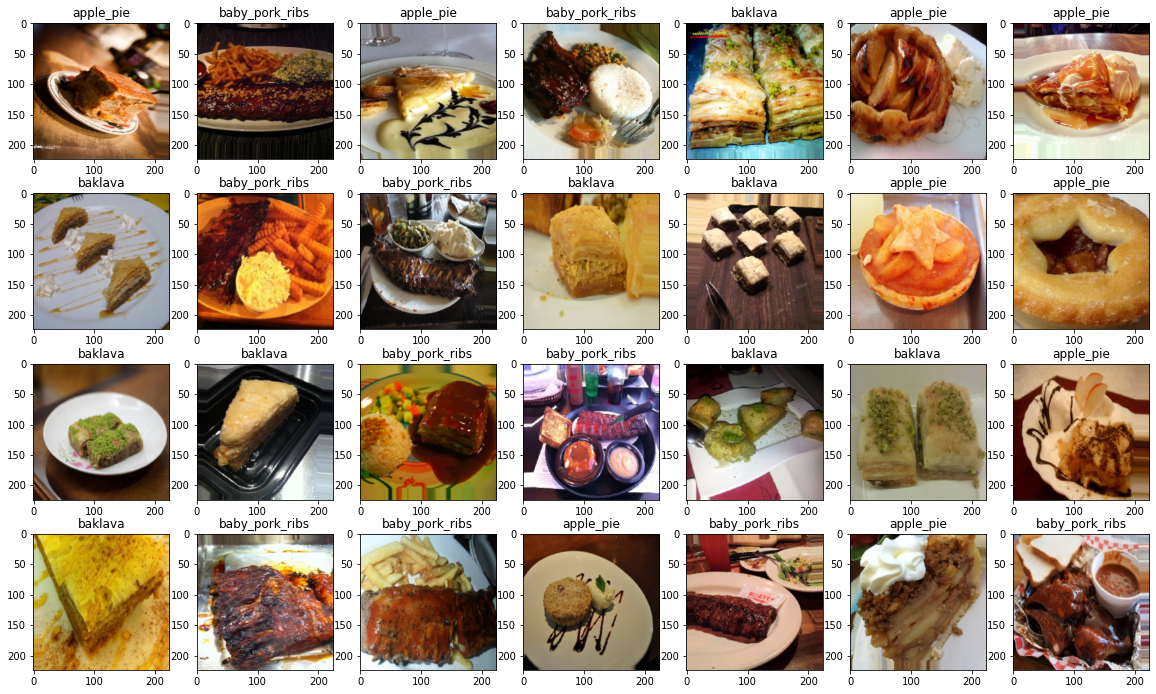

In [ ]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava'}
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

**Modelling**

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', 
                 activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, 
                               save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)       

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=2250/64,
                              validation_data=test_generator,validation_steps=750/64, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
35/35 [==============================] - 35s 980ms/step - loss: 1.3182 - accuracy: 0.3540 - val_loss: 1.0582 - val_accuracy: 0.4480

Epoch 00001: val_loss improved from inf to 1.05819, saving model to model.hdf5
Epoch 2/100
35/35 [==============================] - 34s 970ms/step - loss: 1.0556 - accuracy: 0.4838 - val_loss: 1.0389 - val_accuracy: 0.4813

Epoch 00002: val_loss improved from 1.05819 to 1.03890, saving model to model.hdf5
Epoch 3/100
35/35 [==============================] - 34s 964ms/step - loss: 0.9978 - accuracy: 0.5115 - val_loss: 0.9100 - val_accuracy: 0.5827

Epoch 00003: val_loss improved from 1.03890 to 0.90999, saving model to model.hdf5
Epoch 4/100
35/35 [==============================] - 34s 973ms/step - loss: 0.9177 - accuracy: 0.5629 - val_loss: 0.8689 - val_accuracy: 0.5653

Epoch 00004: val_loss improved from 0.90999 to 0.86893, saving model to model.hdf5
Epoch 5/100
35/35 [==============================] - 34s 971ms/step - loss: 0.8500 - accurac

Stopped at epoch 80 after waiting (patience) for 10 epochs with no improvement on val_loss

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
import torch
model_save_name = 'modelsaved.hdf5'
path = F"/content/drive/MyDrive/Colab Projects/{model_save_name}" 
torch.save(model.save("{model_save_name}"), path)

INFO:tensorflow:Assets written to: {model_save_name}/assets


In [ ]:
# # load weights from upload files
# model.load_weights('../input/model-v17/model_v17.hdf5')

# load weights from training with lowest val_loss
# model.load_weights('../working/model.hdf5')

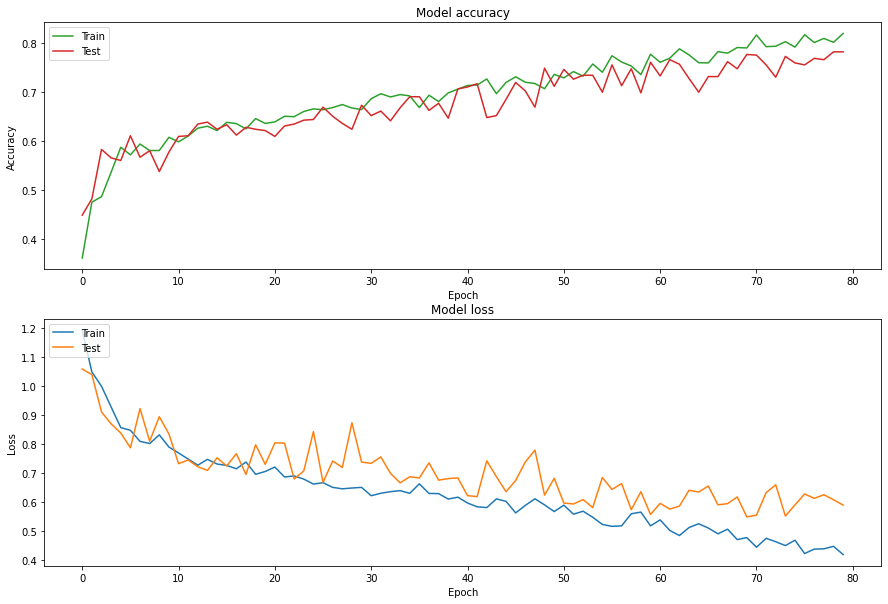

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

**Evaluate results**

In [ ]:
# create another generator for all test images in a single batch (750 photos total in test)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        f_test_path,
        target_size=(224,224),
        batch_size=750)

Found 750 images belonging to 3 classes.


Prediction

In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 78.3%


Randomly check 10 predictions

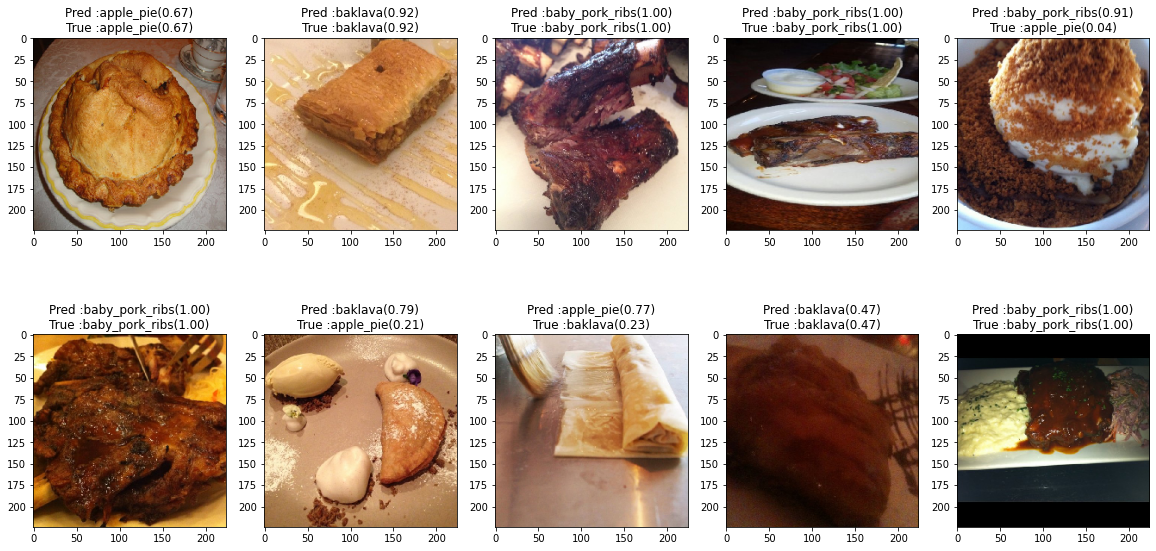

In [ ]:
#ind = np.random.randint(1,len(x_test),10)
f, ax=plt.subplots(2,5,figsize=(20,10))
#for i,j in enumerate(ind):
#for i,j in enumerate(ind):
for k in range(2):
  for l in range(5):
      j=np.random.randint(1,len(x_test))
      ax[k,l].imshow(x_test[j])
      ax[k,l].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                            (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                            classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))

**Confusion Matrix**

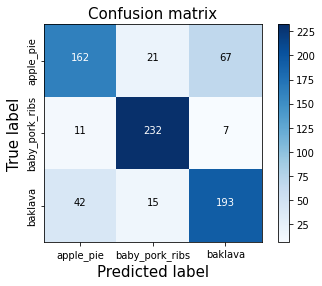

In [ ]:
def plot_confusion_matrix(cm):    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['apple_pie','baby_pork_ribs','baklava']
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0,1,2], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

Inspect the predictions with wrong labels

In [ ]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

In [ ]:
show_wrongest_label(x_test,y_test,y_pred_conf)

Output hidden; open in https://colab.research.google.com to view.